# Análise Exploratória dos Dados da Base MIMIC-III

O MIMIC (Medical Information Mart for Intensive Care) é um grande banco de dados disponível gratuitamente que inclui dados relacionados à saúde não identificados de pacientes que foram admitidos nas unidades de cuidados intensivos do Beth Israel Deaconess Medical Center.

O MIMIC é composto por dados coletados de dois sistemas de informações clínicas diferentes: CareVue e MetaVision.

Nesta versão da base MIMIC temos atendimentos efetuados de **01/06/2001** a **10/10/2012**.

Número de atendimentos: **58.976**

Número de pacientes atendidos: **46.520**

## Objetivo

Compreender as principais características da base do MIMIC-III, que é uma base muito relevante para estudo de doenças e criação de modelos. A partir da análise exploratória, será possível entender a natureza dos dados aqui presentes e de que formas ela pode ser útil em estudos futuros, como na própria dissertação.

## Resultados

Imports das bibliotecas

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Para não truncar os valores presentes nos dataframes para exibição
pd.set_option('display.max_colwidth', None)

### Pacientes

Número de pacientes

In [3]:
patients_df = pd.read_csv('C:\csvMimic\\patients-full.csv')
tam_patients  = patients_df.shape[0]
tam_patients

46520

Número de pacientes por gênero

F    20399
M    26121
Name: gender, dtype: int64


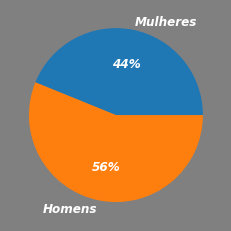

In [4]:
print(patients_df['gender'].value_counts(ascending=True, normalize=False))
plt.figure(facecolor='grey')
plt.pie(patients_df['gender'].value_counts(ascending=True), labels = ['Mulheres', 'Homens'], autopct='%.0f%%', textprops={'fontsize': 12, 'color': 'white', 'style': 'oblique', 'weight': 'bold'})
plt.show()

Temos que a quantidade de homens e mulheres é próxima, sem grande disparidade.

Qual a taxa de sobrevivência destes pacientes?

In [5]:
survival_total = pd.DataFrame(data=patients_df['expire_flag'].value_counts(ascending=True).reset_index(name='total'))
survival_total['percentual'] = (survival_total['total'] / tam_patients * 100).round(2)
survival_total.rename(columns={'index': 'morreu'}, inplace=True)
survival_total.loc[survival_total['morreu'] == 0, 'morreu'] = 'não'
survival_total.loc[survival_total['morreu'] == 1, 'morreu'] = 'sim'
survival_total

,morreu,total,percentual
0,sim,15759,33.88
1,não,30761,66.12


In [6]:
survival_total_by_gender = patients_df.groupby('expire_flag')['gender'].value_counts().reset_index(name='total')
survival_total_by_gender['percentual'] = (survival_total_by_gender['total'] / tam_patients * 100).round(2)
gs_df = pd.DataFrame(data=survival_total_by_gender)
gs_df.rename(columns={'expire_flag': 'morreu', 'gender': 'gênero'}, inplace=True)
gs_df.loc[gs_df['morreu'] == 0, 'morreu'] = 'não'
gs_df.loc[gs_df['morreu'] == 1, 'morreu'] = 'sim'
gs_df

,morreu,gênero,total,percentual
0,não,M,17597,37.83
1,não,F,13164,28.30
2,sim,M,8524,18.32
3,sim,F,7235,15.55


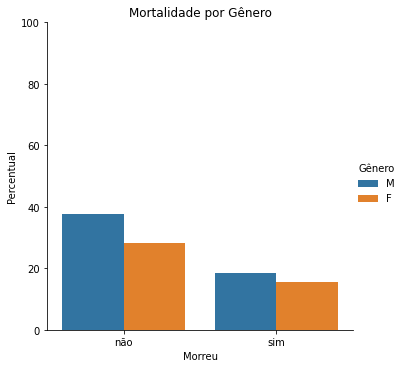

In [403]:
ax = sns.catplot(data=gs_df, x='morreu', y='percentual', kind='bar', hue='gênero')
ax.set(title ="Mortalidade por Gênero", xlabel='Morreu', ylabel='Percentual', ylim=(0,100))
sns.move_legend(ax, "center right", title='Gênero')
ax

A maioria dos pacientes sobrevive e dentre eles os homens são maioria.

**Pergunta:** Essas taxas de sobrevivência são confiáveis? Qual a idade destes pacientes?

Distribuição dos pacientes por idade

Os pacientes foram divididos em 3 grupos etários:
- Com idade de 0 a 1 ano : *neonate*
- Com idade acima entre 14 e 89 anos: *adult*
- Acima de 89 anos: *>89*

Observação: Não foram realizados atendimentos em indivíduos entre 2 e 13 anos, por isso estas idades não são contempladas por nenhuma faixa.

Todas as datas na base incluindo a data de nascimento dos pacientes foi alterada para datas randômicas (no passado e no futuro) para resguardar a privacidade das pessoas envolvidas. Para se obter a idade foi efetuado o cálculo via query SQL da diferença entre a data de nascimento e a data do primeiro atendimento do paciente.

Verificando as estatísticas do atributo idade

In [8]:
patients_df['first_admit_age'].describe()

count    46520.000000
mean        61.878247
std         57.456175
min          0.000000
25%         38.530000
50%         60.490000
75%         75.510000
max        300.000000
Name: first_admit_age, dtype: float64

Os pacientes com idade superior a 89 anos tiveram a idade alterada para 300 na base do MIMIC-III. No site da base é informado que estes pacientes que tiveram a sua idade alterada para 300 anos tinham média de idade de 91.4. Portanto, calculando a média de idade dos demais pacientes de forma apartada é possível chegarmos à real média de idade dos pacientes atendidos.

In [9]:
neonate_df = patients_df.query("age_group_first_admission == 'neonate'")
adults_df = patients_df.query("age_group_first_admission == 'adult'")
elderly_df = patients_df.query("age_group_first_admission == '>89'")

neonate_mean = neonate_df['first_admit_age'].mean()
adults_mean = adults_df['first_admit_age'].mean()
elderly_mean = 91.4

total_mean = ((neonate_mean + adults_mean + elderly_mean)/3).round(2)
no_neonate_mean = ((adults_mean + elderly_mean)/2).round(2)
print('Média total da idade dos pacientes:', total_mean)
print('Média total da idade dos pacientes excluindo recém-nascidos:', no_neonate_mean)

Média total da idade dos pacientes: 51.21
Média total da idade dos pacientes excluindo recém-nascidos: 76.82


Histograma da idade dos pacientes

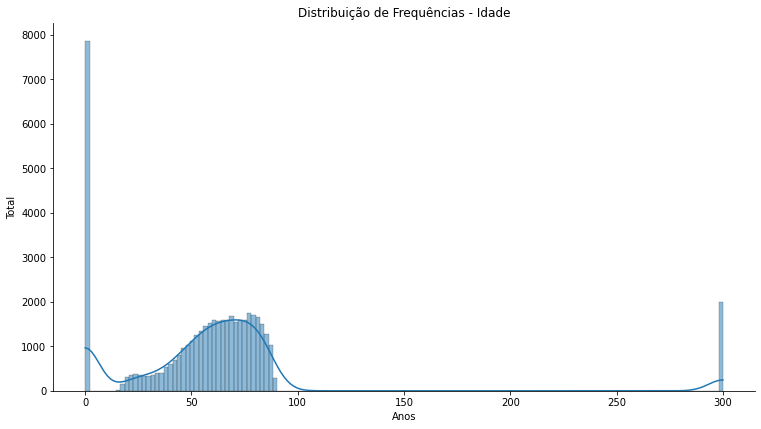

In [404]:
ax = sns.displot(patients_df.first_admit_age, kde = True)
ax.figure.set_size_inches(12,6)
ax.set(title ="Distribuição de Frequências - Idade", xlabel='Anos', ylabel='Total')
ax

Pelo histograma acima a presença de três grupos etários se torna ainda mais evidente. Abaixo, apenas para fins de comprovação, não temos na base pacientes com idade entre 2 e 13 anos.

In [11]:
patients_df.query('first_admit_age > 1 and first_admit_age < 14')

,subject_id,dob,gender,expire_flag,first_admit_age,last_admit_age,age_group_first_admission,age_group_last_admission,first_admittime,last_admittime,ethnicity,language_p,religion,marital_status


Distribuição de idade entre os adultos

<AxesSubplot:title={'center':'Distribuição de Frequências Por Gênero- Idade Adulta'}, xlabel='Anos', ylabel='Total'>

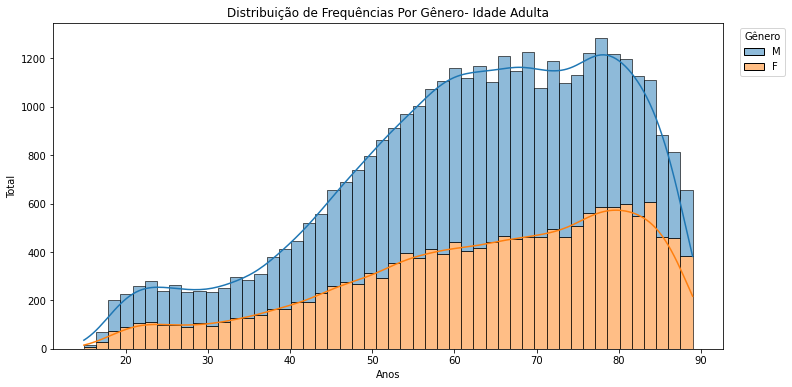

In [428]:
ax = sns.histplot(data=adults_df, x='first_admit_age', kde = True, hue='gender', multiple="stack")
ax.figure.set_size_inches(12,6) 
ax.set(title ="Distribuição de Frequências Por Gênero- Idade Adulta", xlabel='Anos', ylabel='Total')
sns.move_legend(ax, "upper right", title='Gênero', bbox_to_anchor=(1.1, 1))
ax

O intervalo de idades na faixa adulta é muito grande. Vamos plotar um boxplot das idades desta faixa para verificar mais claramente em que intervalo de idades estão concentrados a maior parte dos atendimentos.

<AxesSubplot:title={'center':'Idade - Grupo Adulto'}, xlabel='Anos', ylabel='Sexo'>

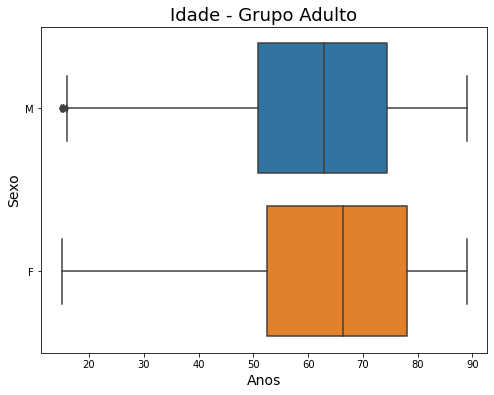

In [13]:
ax = sns.boxplot(x = 'first_admit_age', y='gender', data=adults_df)
ax.figure.set_size_inches(8,6)
ax.set_title('Idade - Grupo Adulto', fontsize=18)
ax.set_xlabel('Anos', fontsize=14)
ax.set_ylabel('Sexo', fontsize=14)
ax

Taxa de mortalidade por grupo etário

In [14]:
# patients_age_gender_mortality = patients_by_age.groupby(['expire_flag', 'age_group', 'gender'], as_index=False).agg('count')
patients_mortality_rate = patients_df.groupby(['expire_flag', 'age_group_first_admission'])['gender'].value_counts().reset_index(name='total')
patients_mortality_rate['percentual'] = (patients_mortality_rate['total'] / tam_patients * 100).round(2)
patients_mortality_rate.rename(columns={'expire_flag': 'morreu', 'gender': 'gênero', 'age_group_first_admission': 'faixa etária'}, inplace=True)
patients_mortality_rate

,morreu,faixa etária,gênero,total,percentual
0,0,>89,F,356,0.77
1,0,>89,M,155,0.33
2,0,adult,M,13235,28.45
3,0,adult,F,9207,19.79
4,0,neonate,M,4207,9.04
5,0,neonate,F,3601,7.74
6,1,>89,F,938,2.02
7,1,>89,M,542,1.17
8,1,adult,M,7944,17.08
9,1,adult,F,6269,13.48


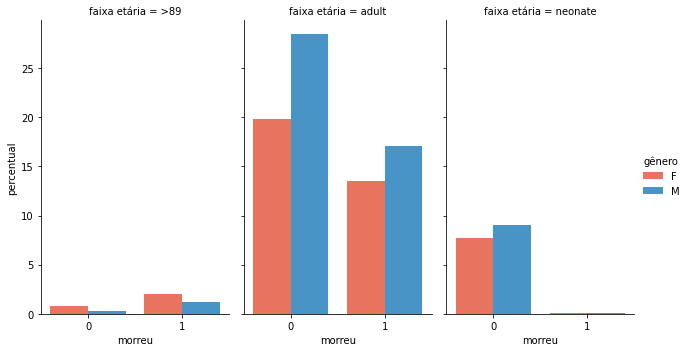

In [15]:
ax = sns.catplot(data=patients_mortality_rate, x='morreu', y='percentual', kind='bar', hue='gênero', col='faixa etária', aspect=.6, palette=dict(F="tomato", M="#3498db"))
ax

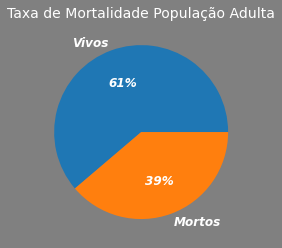

In [16]:
plt.figure(facecolor='grey')
plt.pie(adults_df['expire_flag'].value_counts(), autopct='%.0f%%', labels = ['Vivos', 'Mortos'], textprops={'fontsize': 12, 'color': 'white', 'style': 'oblique', 'weight': 'bold'})
plt.title('Taxa de Mortalidade População Adulta', color='white', fontsize=14)
plt.show()

#### Informações Demográficas

Estado Civil

(0.0, 46520.0)

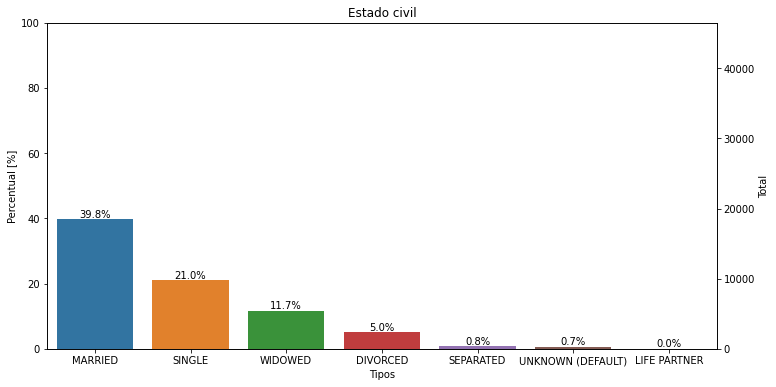

In [429]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="marital_status", data=patients_df)

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('Estado civil')
ax.set_xlabel('Tipos')
ax2.set_ylabel('Percentual [%]')
ax.set_ylabel('Total')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_patients), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_patients)

Grupos Étnicos

In [18]:
print('Quantidade de grupos étnicos: ', patients_df['ethnicity'].unique().shape[0])
patients_df['ethnicity'].value_counts()

Quantidade de grupos étnicos:  41


WHITE                                                       32115
UNKNOWN/NOT SPECIFIED                                        4133
BLACK/AFRICAN AMERICAN                                       3589
HISPANIC OR LATINO                                           1335
ASIAN                                                        1297
OTHER                                                        1289
UNABLE TO OBTAIN                                              787
PATIENT DECLINED TO ANSWER                                    489
ASIAN - CHINESE                                               231
BLACK/CAPE VERDEAN                                            167
HISPANIC/LATINO - PUERTO RICAN                                154
WHITE - RUSSIAN                                               119
MULTI RACE ETHNICITY                                          109
BLACK/HAITIAN                                                  75
WHITE - OTHER EUROPEAN                                         71
HISPANIC/L

(0.0, 46520.0)

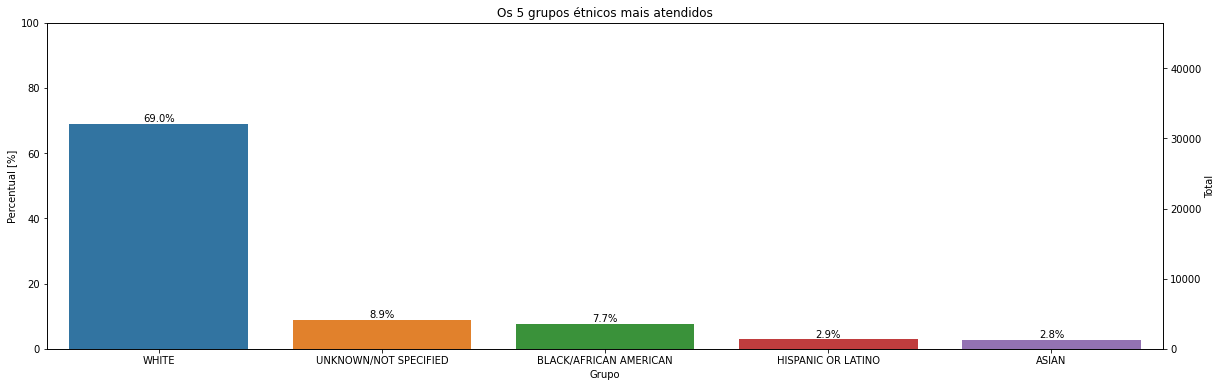

In [430]:
plt.figure(figsize=(20,6))
ax = sns.countplot(x="ethnicity", data=patients_df, order=patients_df.ethnicity.value_counts().iloc[:5].index)

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('Os 5 grupos étnicos mais atendidos')
ax.set_xlabel('Grupo')
ax2.set_ylabel('Percentual [%]')
ax.set_ylabel('Total')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_patients), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_patients)

Línguas

In [20]:
print('Quantidade de idiomas: ', patients_df['language_p'].unique().shape[0])
patients_df['language_p'].value_counts()

Quantidade de idiomas:  76


ENGL    21783
SPAN      801
RUSS      533
PTUN      525
CANT      320
        ...  
*PHI        1
*PUN        1
*DEA        1
*MAN        1
*LIT        1
Name: language_p, Length: 75, dtype: int64

(0.0, 46520.0)

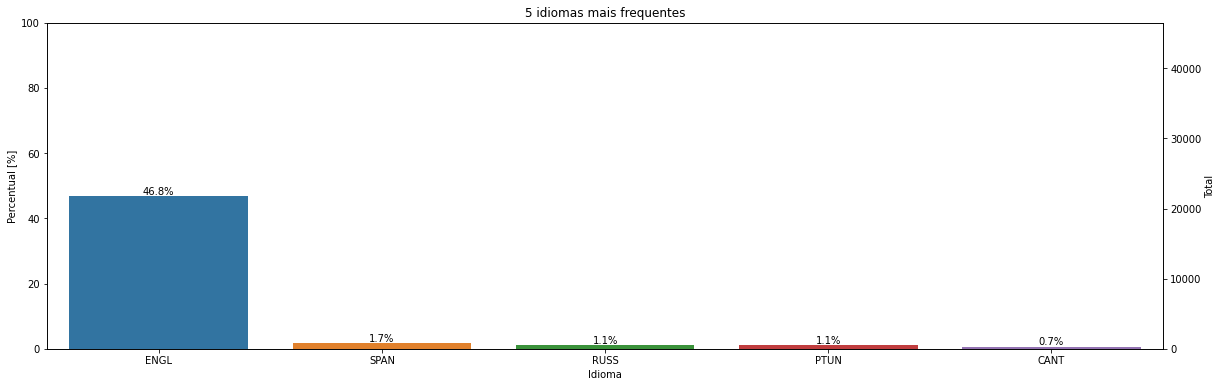

In [431]:
plt.figure(figsize=(20,6))
ax = sns.countplot(x="language_p", data=patients_df, order=patients_df.language_p.value_counts().iloc[:5].index)

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('5 idiomas mais frequentes')
ax.set_xlabel('Idioma')
ax2.set_ylabel('Percentual [%]')
ax.set_ylabel('Total')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_patients), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_patients)

Religiões

In [22]:
print('Quantidade de religiões: ', patients_df['religion'].unique().shape[0])
patients_df['religion'].value_counts()

Quantidade de religiões:  21


CATHOLIC                  15714
NOT SPECIFIED              9546
UNOBTAINABLE               7655
PROTESTANT QUAKER          5133
JEWISH                     3841
OTHER                      2089
EPISCOPALIAN                593
CHRISTIAN SCIENTIST         361
GREEK ORTHODOX              326
BUDDHIST                    196
MUSLIM                      158
JEHOVAH'S WITNESS           104
UNITARIAN-UNIVERSALIST      104
HINDU                       101
ROMANIAN EAST. ORTH          68
7TH DAY ADVENTIST            56
BAPTIST                      20
HEBREW                       14
METHODIST                     6
LUTHERAN                      1
Name: religion, dtype: int64

(0.0, 46520.0)

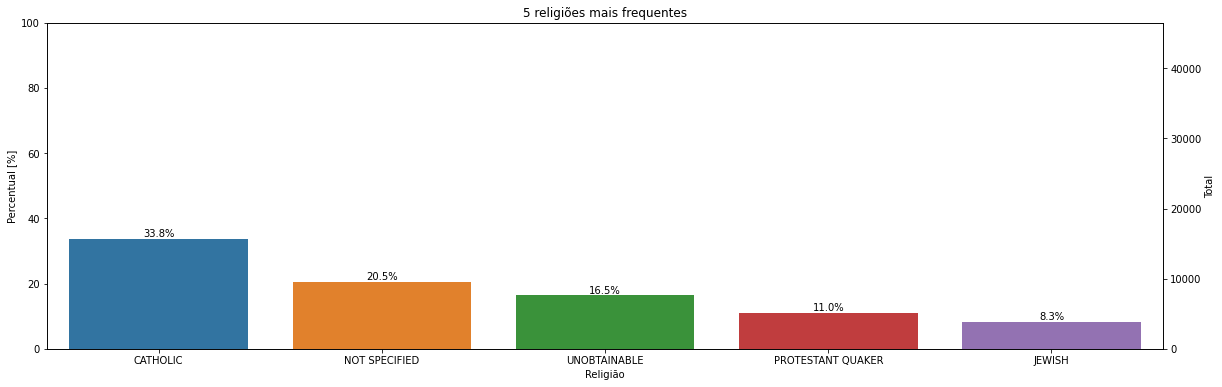

In [432]:
plt.figure(figsize=(20,6))
ax = sns.countplot(x="religion", data=patients_df, order=patients_df.religion.value_counts().iloc[:5].index)

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('5 religiões mais frequentes')
ax.set_xlabel('Religião')
ax2.set_ylabel('Percentual [%]')
ax.set_ylabel('Total')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_patients), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_patients)

### Atendimentos

#### Dados Iniciais

Número de atendimentos

In [24]:
admissions_df = pd.read_csv('C:\csvMimic\\admissions-with-gender.csv')
tam_admissions  = admissions_df.shape[0]
tam_admissions

58976

Quantidade de atendimentos por paciente

In [25]:
qtde_adm_patients = pd.read_csv('C:\csvMimic\\atendimentos-por-qtde-pacientes.csv')
print("Número de pacientes com um único atendimento: ", qtde_adm_patients.cont[0])
print("Número de pacientes com mais de um atendimento: ", qtde_adm_patients['cont'].sum() - qtde_adm_patients.cont[0])

Número de pacientes com um único atendimento:  38983
Número de pacientes com mais de um atendimento:  7537


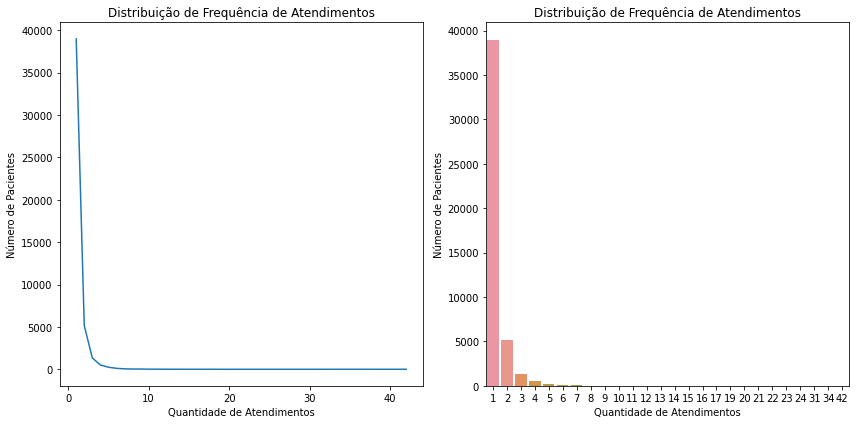

In [26]:
f, axs = plt.subplots(1, 2, figsize=(12, 6)) #gridspec_kw=dict(width_ratios=[4, 3])
sns.lineplot(data=qtde_adm_patients,  x='qtd_adm', y='cont', ax=axs[0])
sns.barplot(data=qtde_adm_patients,  x='qtd_adm', y='cont', ax=axs[1])
axs[0].set(title ="Distribuição de Frequência de Atendimentos", xlabel='Quantidade de Atendimentos', ylabel = 'Número de Pacientes')
axs[1].set(title ="Distribuição de Frequência de Atendimentos", xlabel='Quantidade de Atendimentos', ylabel = 'Número de Pacientes')
f.tight_layout()

A maioria dos pacientes foi ao hospital uma única vez.

Tipos de Atendimento

Temos na base 4 tipos possíveis de tipos de atendimento. São eles:
- emergency: Atendimentos não planejados
- urgent: Atendimentos não planejados
- elective: Atendimentos planejados
- newborn: Nascimentos

Os mantenedores do MIMIC-III indicam que as categorias *emergency* e *urgent* podem ser agrupadas, por terem a mesma natureza.

(0.0, 58976.0)

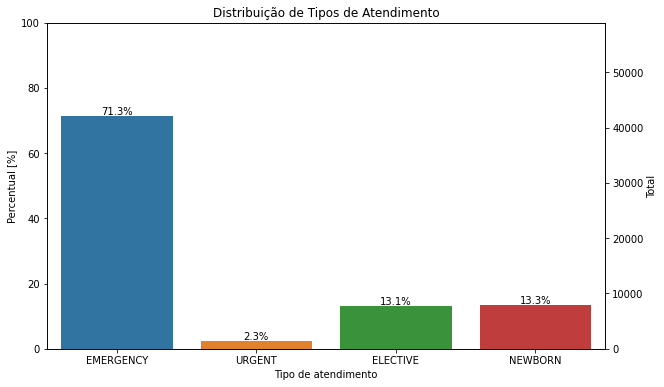

In [433]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="admission_type", data=admissions_df, order=['EMERGENCY', 'URGENT', 'ELECTIVE', 'NEWBORN'])
plt.title('Distribuição de Tipos de Atendimento')
plt.xlabel('Tipo de atendimento')

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('Percentual [%]')
ax.set_ylabel('Total')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_admissions), (x.mean(), y), ha='center', va='bottom')
ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_admissions)

Tipos de planos de saúde/origem do custeio dos atendimentos

(0.0, 58976.0)

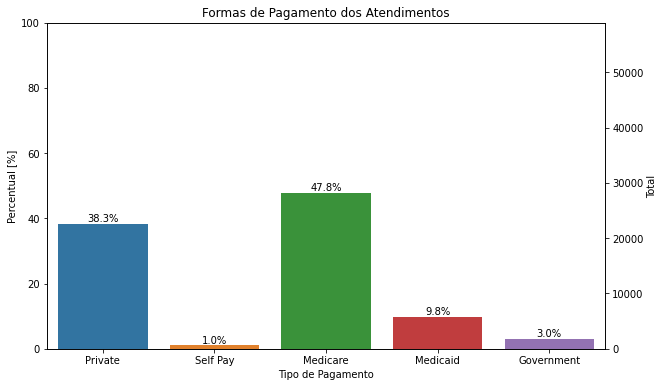

In [435]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="insurance", data=admissions_df, order=['Private', 'Self Pay', 'Medicare', 'Medicaid', 'Government'])

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('Formas de Pagamento dos Atendimentos')
ax2.set_ylabel('Percentual [%]')
ax.set_xlabel('Tipo de Pagamento')
ax.set_ylabel('Total')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_admissions), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_admissions)

#### Duração da permanência dos pacientes no hospital

Verificando se temos valores nulos nas datas

In [28]:
print(admissions_df.isnull().values.any())
nan_columns = admissions_df.isna().any()
admissions_df.columns[nan_columns].tolist()

True


['deathtime',
 'language',
 'religion',
 'marital_status',
 'edregtime',
 'edouttime',
 'diagnosis']

Dado que não temos dados faltantes, vamos calcular a duração de cada atendimento em dias

In [29]:
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])

admissions_df['duration'] = (admissions_df['dischtime'] - admissions_df['admittime']).dt.days

Duração média dos atendimentos no geral

In [30]:
admissions_df.duration.describe()

count    58976.000000
mean         9.610672
std         12.452546
min         -1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max        294.000000
Name: duration, dtype: float64

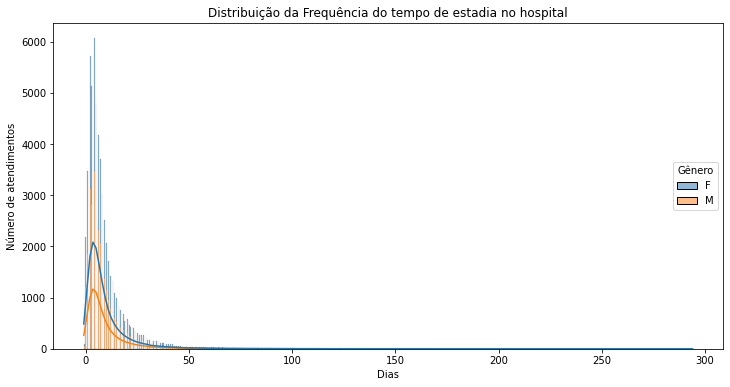

In [436]:
plt.figure(figsize=(12,6))
ax = sns.histplot(x="duration", data=admissions_df, kde = True, hue='gender', multiple="stack")
plt.title('Distribuição da Frequência do tempo de estadia no hospital')
ax.set_xlabel('Dias')
ax.set_ylabel('Número de atendimentos')
sns.move_legend(ax, "center right", title='Gênero')


As mulheres ficam menos tempo no hospital em geral.

Observando outliers na duração dos atendimentos em geral

<AxesSubplot:title={'center':'Boxplot - Tempo de permanência no hospital'}, xlabel='Dias', ylabel='Total'>

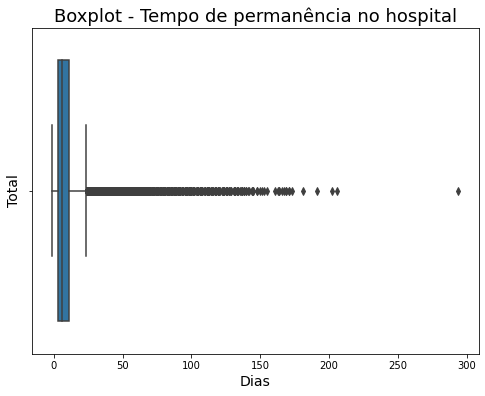

In [437]:
ax = sns.boxplot(x = 'duration', data=admissions_df, orient='h')
ax.figure.set_size_inches(8,6)
ax.set_title('Boxplot - Tempo de permanência no hospital', fontsize=18)
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Total', fontsize=14)
ax

Verificando o tempo de permanência com a mortalidade

<AxesSubplot:title={'center':'Boxplot - Duração de Atendimentos'}, xlabel='Dias', ylabel='Mortalidade'>

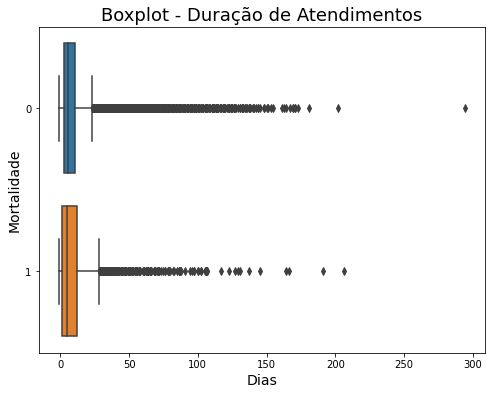

In [33]:
ax = sns.boxplot(x = 'duration', y='hospital_expire_flag', data=admissions_df, orient='h')
ax.figure.set_size_inches(8,6)
ax.set_title('Boxplot - Duração de Atendimentos', fontsize=18)
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Mortalidade', fontsize=14)
ax

Boxplot do tempo de permanência por gênero

<AxesSubplot:title={'center':'Boxplot - Tempo de permanência por gênero'}, xlabel='Dias', ylabel='Gênero'>

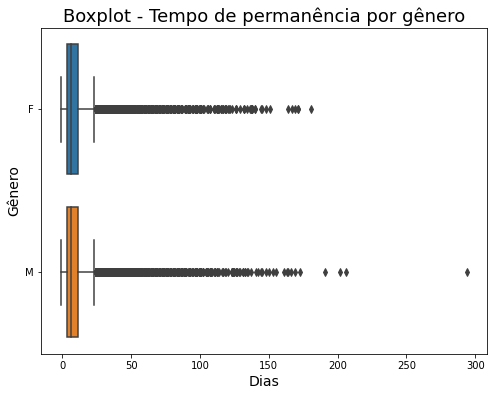

In [34]:
ax = sns.boxplot(x = 'duration', y='gender', data=admissions_df, orient='h')
ax.figure.set_size_inches(8,6)
ax.set_title('Boxplot - Tempo de permanência por gênero', fontsize=18)
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Gênero', fontsize=14)
ax

Duração de atendimento na emergência

In [438]:
print("Total de atendimentos: ", admissions_df.shape[0])
emergency_admissions = admissions_df.dropna()
print("Quantidade de atendimentos na emergência: ", emergency_admissions.shape[0])

Total de atendimentos:  58976
Quantidade de atendimentos na emergência:  2053


In [439]:
# emergency_admissions.loc[row_indexer,col_indexer] = pd.to_datetime(emergency_admissions['edregtime'])
emergency_admissions.loc[:, 'edregtime'] = pd.to_datetime(emergency_admissions['edregtime'])
emergency_admissions.loc[:, 'edouttime'] = pd.to_datetime(emergency_admissions['edouttime'])

# convertendo segundos em horas
emergency_admissions.loc[:, 'duration_em'] = ((emergency_admissions['edouttime'] - emergency_admissions['edregtime']).dt.seconds)/3600
print(emergency_admissions.duration_em.describe())

count    2053.000000
mean        5.061560
std         2.657447
min         0.066667
25%         3.283333
50%         4.600000
75%         6.250000
max        23.383333
Name: duration_em, dtype: float64


C:\Users\camila.gusmao\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\camila.gusmao\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Duração média da estadia dos pacientes por tipo de atendimento

In [37]:
admissions_df.groupby('admission_type').agg('mean')['duration']

admission_type
ELECTIVE      8.563717
EMERGENCY     9.469397
NEWBORN      11.030777
URGENT       11.740269
Name: duration, dtype: float64

### Serviços

Quantidade de serviços realizados

In [38]:
services_df = pd.read_csv('C:\csvMimic\\services-with-gender-age-group.csv')
tam_services = services_df.shape[0]
tam_services

73343

Os serviços são persistidos na base por meio de mnemônicos. Segue abaixo um dicionário com a descrição de cada um deles e quantidade por tipo de serviço

In [39]:
serv_types_dict = {
    'CMED':	   'Cardiac Medical - for non-surgical cardiac related admissions',
    'CSURG':   'Cardiac Surgery - for surgical cardiac admissions',
    'DENT':	   'Dental - for dental/jaw related admissions',
    'ENT':     'Ear, nose, and throat - conditions primarily affecting these areas',
    'GU':      'Genitourinary - reproductive organs/urinary system',
    'GYN':	   'Gynecological - female reproductive systems and breasts',
    'MED':	   'Medical - general service for internal medicine',
    'NB':	   'Newborn - infants born at the hospital',
    'NBB':	   'Newborn baby - infants born at the hospital',
    'NMED':	   'Neurologic Medical - non-surgical, relating to the brain',
    'NSURG':   'Neurologic Surgical - surgical, relating to the brain',
    'OBS':	   'Obstetrics - conerned with childbirth and the care of women giving birth',
    'ORTHO':   'Orthopaedic - surgical, relating to the musculoskeletal system',
    'OMED':	   'Orthopaedic medicine - non-surgical, relating to musculoskeletal system',
    'PSURG':   'Plastic - restortation/reconstruction of the human body (including cosmetic or aesthetic)',
    'PSYCH':   'Psychiatric - mental disorders relating to mood, behaviour, cognition, or perceptions',
    'SURG':	   'Surgical - general surgical service not classified elsewhere',
    'TRAUM':   'Trauma - injury or damage caused by physical harm from an external source',
    'TSURG':   'Thoracic Surgical - surgery on the thorax, located between the neck and the abdomen',
    'VSURG':   'Vascular Surgical - surgery relating to the circulatory system'
}
serv_types = services_df['curr_service'].value_counts().rename_axis('tipo').reset_index(name='total')
serv_types['desc'] = serv_types.apply(lambda x: serv_types_dict.get(x['tipo']), axis=1)
serv_types

,tipo,total,desc
0,MED,24866,Medical - general service for internal medicine
1,CMED,9135,Cardiac Medical - for non-surgical cardiac related admissions
2,CSURG,7911,Cardiac Surgery - for surgical cardiac admissions
3,NB,7806,Newborn - infants born at the hospital
4,SURG,5514,Surgical - general surgical service not classified elsewhere
5,NSURG,4100,"Neurologic Surgical - surgical, relating to the brain"
6,TRAUM,3137,Trauma - injury or damage caused by physical harm from an external source
7,NMED,2957,"Neurologic Medical - non-surgical, relating to the brain"
8,OMED,2286,"Orthopaedic medicine - non-surgical, relating to musculoskeletal system"
9,VSURG,1455,Vascular Surgical - surgery relating to the circulatory system


<AxesSubplot:title={'center':'Distribuição de Frequências - Serviços'}, xlabel='Tipos de Serviço', ylabel='total'>

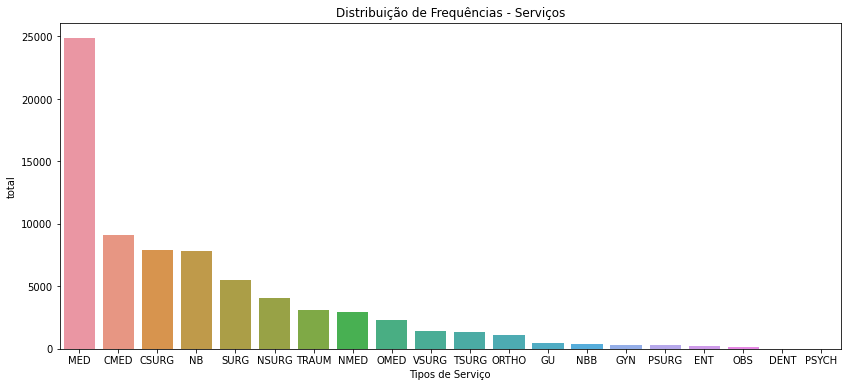

In [40]:
ax = sns.barplot(data=serv_types,  x='tipo', y='total')
ax.figure.set_size_inches(14,6) 
ax.set(title ="Distribuição de Frequências - Serviços", xlabel='Tipos de Serviço')
ax

Visualização de Serviços do hospital por gênero

<AxesSubplot:title={'center':'Distribuição de Frequências por Gênero- Serviços'}, xlabel='Tipos de Serviço', ylabel='total'>

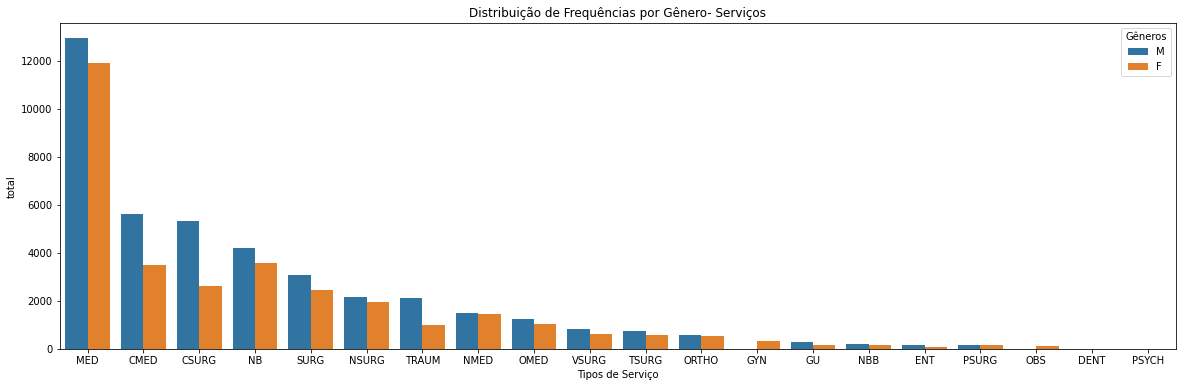

In [41]:
aux = services_df.groupby(['curr_service'])['gender'].value_counts().reset_index(name='total')
aux.sort_values('total', ascending=False, inplace=True)
ax = sns.barplot(data=aux,  x='curr_service', y='total', hue='gender')
ax.figure.set_size_inches(20,6) 
ax.set(title ="Distribuição de Frequências por Gênero- Serviços", xlabel='Tipos de Serviço')
sns.move_legend(ax, "upper right", title='Gêneros')
ax

Serviços por faixa etária

<AxesSubplot:title={'center':'Distribuição de serviços por faixa etária'}, xlabel='Tipos de Serviço', ylabel='total'>

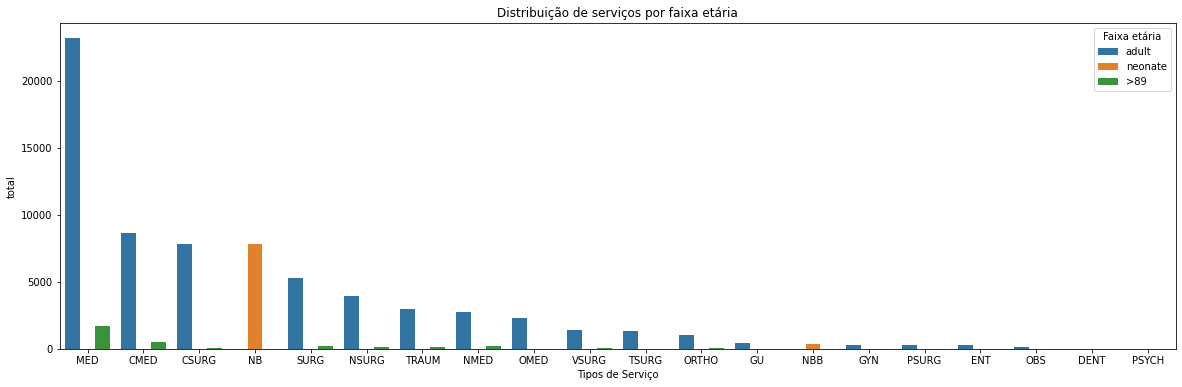

In [42]:
aux = services_df.groupby(['curr_service'])['age_group'].value_counts().reset_index(name='total')
aux.sort_values('total', ascending=False, inplace=True)
ax = sns.barplot(data=aux,  x='curr_service', y='total', hue='age_group')
ax.figure.set_size_inches(20,6) 
ax.set(title ="Distribuição de serviços por faixa etária", xlabel='Tipos de Serviço')
sns.move_legend(ax, "upper right", title='Faixa etária') #bbox_to_anchor=(.55, .45)
ax

### UTI

Temos na base do MIMIC-III 7 tipos distintos de Unidades de Tratamento Intensivo. Segue abaixo um dicionário contendo o mnemônico e a descrição de cada unidade

In [43]:
icu_dict = {
    'CCU':	 'Coronary care unit',
    'CSRU':  'Cardiac surgery recovery unit',
    'MICU':	 'Medical intensive care unit',
    'NICU':  'Neonatal intensive care unit',
    'NWARD': 'Neonatal ward',
    'SICU':	 'Surgical intensive care unit',
    'TSICU': 'Trauma/surgical intensive care unit'
}

Quantidade de pacientes que foram para UTI

In [139]:
icu_df = pd.read_csv('C:\csvMimic\\v1_4\ICUSTAYS.csv')
qtd_patients_icu = len(icu_df['SUBJECT_ID'].unique())
print(qtd_patients_icu, "pacientes foram para UTI.")
print("Percentual de pacientes que foram para a UTI:", round(qtd_patients_icu/tam_patients * 100, 2))

46476 pacientes foram para UTI.
Percentual de pacientes que foram para a UTI: 99.91


In [45]:
icu_df.LAST_CAREUNIT.unique()

array(['MICU', 'CCU', 'SICU', 'NICU', 'TSICU', 'CSRU'], dtype=object)

Pelo print acima, vemos que embora na documentação da base tenhamos 7 tipos de UTI, nenhum paciente foi registrado na unidade NWARD.

Verificando a quantidade de passagens pela UTI para cada paciente

In [44]:
aux = icu_df['SUBJECT_ID'].value_counts().rename_axis('paciente').reset_index(name='total')
aux

,paciente,total
0,13033,41
1,109,38
2,11861,35
3,5060,31
4,20643,25
...,...,...
46471,16413,1
46472,16414,1
46473,16415,1
46474,17126,1


Pela tabela acima fica nítido que os pacientes em geral têm várias passagens pelas UTIs presentes no hospital, podendo ser a mesma ou não. Mas como então saber em qual UTI determinado paciente passou mais tempo?

In [114]:
def getPatientsAdmissionsPerUCI():
    icu_patient_list= list()
    for index, row in patients_df.iterrows():
        id_patient = row['subject_id']

        # Passagens do paciente pela UTI
        aux_df = icu_df.query('SUBJECT_ID == ' + str(id_patient))

        # Separando por atendimento no hospital
        admissions_ids = aux_df['HADM_ID'].unique()
        for admission_id in admissions_ids:
            adm_df = aux_df.query('HADM_ID == ' + str(admission_id) + '')

            # Separando por tipo de UTI
            res_micu = adm_df.query("LAST_CAREUNIT == 'MICU'")
            micu_num = res_micu.shape[0]
            micu_los = res_micu.LOS.sum()

            res_ccu = adm_df.query("LAST_CAREUNIT == 'CCU'")
            ccu_num = res_ccu.shape[0]
            ccu_los = res_ccu.LOS.sum()

            res_sicu = adm_df.query("LAST_CAREUNIT == 'SICU'")
            sicu_num = res_sicu.shape[0]
            sicu_los = res_sicu.LOS.sum()

            res_nicu = adm_df.query("LAST_CAREUNIT == 'NICU'")
            nicu_num = res_nicu.shape[0]
            nicu_los = res_nicu.LOS.sum()

            res_tsicu = adm_df.query("LAST_CAREUNIT == 'TSICU'")
            tsicu_num = res_tsicu.shape[0]
            tsicu_los = res_tsicu.LOS.sum()

            res_csru = adm_df.query("LAST_CAREUNIT == 'CSRU'")
            csru_num = res_csru.shape[0]
            csru_los = res_csru.LOS.sum()

            res_nward = adm_df.query("LAST_CAREUNIT == 'NWARD'")
            nward_num = res_nward.shape[0]
            nward_los = res_nward.LOS.sum()

            res = {
                'subject_id': id_patient,
                'hadm_id': admission_id,
                'micu_num': micu_num,
                'micu_los': micu_los,
                'ccu_num': ccu_num,
                'ccu_los': ccu_los,
                'sicu_num': sicu_num,
                'sicu_los': sicu_los,
                'nicu_num': nicu_num,
                'nicu_los': nicu_los,
                'tsicu_num': tsicu_num,
                'tsicu_los': tsicu_los,
                'csru_num': csru_num,
                'csru_los': csru_los,
                'nward_num': nward_num,
                'nward_los': nward_los
            }
            icu_patient_list.append(res)


        # if len(aux_df.index) == 0:
        #     print('DataFrame is empty!')
    icu_patient_df = pd.DataFrame(data=icu_patient_list)
    icu_patient_df.to_csv('C:\csvMimic\\icu_stays_count.csv')

# getPatientsAdmissionsPerUCI()


Tempo de estadia em cada UTI e número de UTIs visitadas por paciente:

In [170]:
patients_icu_per_admission = pd.read_csv('C:\csvMimic\\icu_stays_count.csv').drop(['Unnamed: 0'], axis=1)
patients_icu_per_admission

,subject_id,hadm_id,micu_num,micu_los,ccu_num,ccu_los,sicu_num,sicu_los,nicu_num,nicu_los,tsicu_num,tsicu_los,csru_num,csru_los,nward_num,nward_los
0,2,163353,0,0.0000,0,0.0,0,0.0000,1,0.0918,0,0.0000,0,0.0000,0,0.0
1,3,145834,1,6.0646,0,0.0,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0
2,4,185777,1,1.6785,0,0.0,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0
3,5,178980,0,0.0000,0,0.0,0,0.0000,1,0.0844,0,0.0000,0,0.0000,0,0.0
4,6,107064,0,0.0000,0,0.0,1,3.6729,0,0.0000,0,0.0000,0,0.0000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57781,99985,176670,1,11.2998,0,0.0,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0
57782,99991,151118,0,0.0000,0,0.0,0,0.0000,0,0.0000,1,3.1426,0,0.0000,0,0.0
57783,99992,197084,1,1.9745,0,0.0,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0
57784,99995,137810,0,0.0000,0,0.0,0,0.0000,0,0.0000,0,0.0000,1,2.1615,0,0.0


Tempo de estadia em cada UTI e número de UTIs visitadas por atendimentos:

In [190]:
# patients_icu_per_admission['subject_id'].max(axis=1) valor máximo na linha
# patients_icu_per_admission['subject_id'].idxmax(axis=1) coluna contendo o valor máximo
admissions_icu_count = patients_icu_per_admission.drop(['subject_id', 'hadm_id'], axis=1).sum(axis=0).rename_axis('icu_type').reset_index(name='total')
admissions_icu_count.sort_index()

,icu_type,total
0,micu_num,21310.0000
1,micu_los,87837.1656
2,ccu_num,7406.0000
3,ccu_los,25523.1895
4,sicu_num,9213.0000
5,sicu_los,46471.1492
6,nicu_num,8100.0000
7,nicu_los,81138.8443
8,tsicu_num,6111.0000
9,tsicu_los,25207.7343


In [335]:
admissions_icu_final = pd.DataFrame(data=icu_df.LAST_CAREUNIT.unique(), columns=['icu'])
los_lst = list()
qtd_lst = list()
for index, row in admissions_icu_final.iterrows():
    prefix = row['icu'].lower()
    los_field = prefix + '_los'
    qtd_field = prefix + '_num'
    aux_los = admissions_icu_count.query('icu_type == ' + '\'' + los_field + '\'')['total'].values[0]
    aux_qtd = admissions_icu_count.query('icu_type == ' + '\'' + qtd_field + '\'')['total'].values[0]
    los_lst.append(aux_los)
    qtd_lst.append(aux_qtd)
admissions_icu_final['los'] = los_lst
admissions_icu_final['total'] = qtd_lst
admissions_icu_final

,icu,los,total
0,MICU,87837.1656,21310.0
1,CCU,25523.1895,7406.0
2,SICU,46471.1492,9213.0
3,NICU,81138.8443,8100.0
4,TSICU,25207.7343,6111.0
5,CSRU,36385.3647,9392.0


In [342]:
admissions_icu_final.sort_values(by='total', ascending=False)

,icu,los,total
0,MICU,87837.1656,21310.0
5,CSRU,36385.3647,9392.0
2,SICU,46471.1492,9213.0
3,NICU,81138.8443,8100.0
1,CCU,25523.1895,7406.0
4,TSICU,25207.7343,6111.0


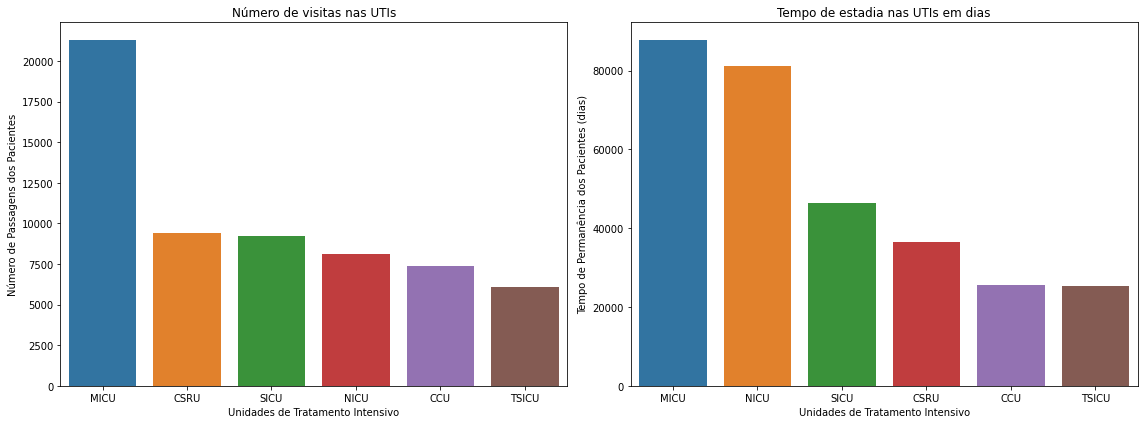

In [351]:
f, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=admissions_icu_final.sort_values(by='total', ascending=False),  x='icu', y='total', ax=axs[0])
sns.barplot(data=admissions_icu_final.sort_values(by='los', ascending=False),  x='icu', y='los', ax=axs[1])

# for item in axs[0].get_xticklabels():
#     item.set_rotation(30)

axs[0].set(title ="Número de visitas nas UTIs", xlabel='Unidades de Tratamento Intensivo', ylabel = 'Número de Passagens dos Pacientes')
axs[1].set(title ="Tempo de estadia nas UTIs em dias", xlabel='Unidades de Tratamento Intensivo', ylabel = 'Tempo de Permanência dos Pacientes (dias)')
f.tight_layout()

### Diagnósticos

Diagnóstico mais relatado

In [389]:
diagnoses_df = pd.read_csv('C:\csvMimic\\diagnoses-with-patients.csv')
diagnoses_mode = diagnoses_df.icd9_code.mode().values[0]
diagnoses_mode_desc = diagnoses_df.query('icd9_code == ' + '\'' + str(diagnoses_mode) + '\'').iloc[0].short_title
print("Diagnóstico mais comum:", diagnoses_mode, "- ", diagnoses_mode_desc)

Diagnóstico mais comum: 4019 -  Hypertension NOS


A descrição acima é uma abreviação para *Unspecified essential hypertension*

Diagnóstico mais obtido por gênero

In [391]:
diagnoses_male_mode = diagnoses_df.query("gender == 'M'").icd9_code.mode().values[0]
diagnoses_female_mode = diagnoses_df.query("gender == 'F'").icd9_code.mode().values[0]
diagnoses_mode_male_desc = diagnoses_df.query('icd9_code == ' + '\'' + str(diagnoses_male_mode) + '\'').iloc[0].short_title
diagnoses_mode_female_desc = diagnoses_df.query('icd9_code == ' + '\'' + str(diagnoses_female_mode) + '\'').iloc[0].short_title
print("Diagnóstico mais comum entre os homens:", diagnoses_male_mode, "- ", diagnoses_mode_male_desc)
print("Diagnóstico mais comum entre as mulheres:", diagnoses_female_mode, "- ", diagnoses_mode_female_desc)

Diagnóstico mais comum entre os homens: 4019 -  Hypertension NOS
Diagnóstico mais comum entre as mulheres: 4019 -  Hypertension NOS


Diagnóstico por grupo etário

In [394]:
diagnoses_neonate_mode = diagnoses_df.query("age_group == 'neonate'").icd9_code.mode().values[0]
diagnoses_mode_neonate_desc = diagnoses_df.query('icd9_code == ' + '\'' + str(diagnoses_neonate_mode) + '\'').iloc[0].short_title
print("Diagnóstico mais comum entre recém-nascidos:", diagnoses_neonate_mode, "- ", diagnoses_mode_neonate_desc)

Diagnóstico mais comum entre recém-nascidos: V053 -  Need prphyl vc vrl hepat


A descrição é uma abreviação para *Need for prophylactic vaccination and inoculation against viral hepatitis*

In [396]:
diagnoses_adults_mode = diagnoses_df.query("age_group == 'adult'").icd9_code.mode().values[0]
diagnoses_mode_adult_desc = diagnoses_df.query('icd9_code == ' + '\'' + str(diagnoses_adults_mode) + '\'').iloc[0].short_title
print("Diagnóstico mais comum entre adultos:", diagnoses_adults_mode, "- ", diagnoses_mode_adult_desc)

Diagnóstico mais comum entre adultos: 4019 -  Hypertension NOS


In [398]:
diagnoses_elderly_mode = diagnoses_df.query("age_group == '>89'").icd9_code.mode().values[0]
diagnoses_mode_elderly_desc = diagnoses_df.query('icd9_code == ' + '\'' + str(diagnoses_elderly_mode) + '\'').iloc[0].short_title
print("Diagnóstico mais comum em pessoas acima de 89 anos:", diagnoses_elderly_mode, "- ", diagnoses_mode_elderly_desc)

Diagnóstico mais comum em pessoas acima de 89 anos: 4280 -  CHF NOS


A descrição é uma abreviação para *Congestive heart failure*